In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']


In [5]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1512560, 25)
(709325, 22)


In [6]:
pp = Preprocess(df_transaction, df_property)

In [7]:
use_features = pp.get_feature_list()

In [8]:
# records of last year
#use_features = ['sqft', 'num_bed', 'num_bath', 'view', 'pool', 'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 'impr_over_land']
#df_track = pp.dataset(feature_set=use_features, valid=True, date=('2015-10-01', '2017-10-01'))
df_track = pp.dataset(feature='delivered', valid=True, date=('2015-10-01', '2017-10-01'))
df_track.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


(68919, 14)

In [9]:
df_track.head()

,view,date,lon,sqft,id,num_bed,sqft_zip_avg,impr_over_land,num_bath,sold_price_zip_avg,sqft_price_zip_avg,sold_price,lat,pool
0,0,2015-10-01,-117.10164,1064,1428580,2.0,2162.542982,1.015708,2.0,698046.052632,334.725439,346500,32.93745,0
50286,0,2015-10-01,-117.07549,1277,1428633,2.0,1113.244663,0.639538,1.0,282327.586207,257.919540,400000,32.74247,0
50287,0,2015-10-01,-117.08364,1366,1428641,2.0,1113.244663,1.055773,2.0,282327.586207,257.919540,418000,32.72620,0
51748,0,2015-10-01,-117.05104,1459,1428713,3.0,1483.899399,0.967124,2.0,354269.144144,246.869369,417500,32.62687,0
51747,0,2015-10-01,-117.08126,814,1428664,2.0,1483.899399,1.357232,1.0,354269.144144,246.869369,175000,32.61402,0


### baseline without segment

In [26]:
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
print(df_track.shape)
monthly_volume = int(df_track.shape[0] / 24)
mm = ModelManager(df_track, use_features, rf, time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 57435, 34452, 11484
[dp] train/valid/test size: 45948, 11487, 11484
[dp] validation step is skipped


(68919, 14)


128244.86642382022

### segment on sold_price
* segment on sold_price is only for experiment, not practical in real case
* 2 segments: <1M, >=1M
* random forest

In [16]:
# < 1M
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
df_track_filter = df_track[df_track['sold_price']<1000000]
print(df_track_filter.shape)
monthly_volume = int(df_track_filter.shape[0] / 24)
mm1 = ModelManager(df_track_filter, use_features, rf, time_series=True)
mm1.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 52373, 31416, 10472
[dp] train/valid/test size: 41898, 10475, 10472
[dp] validation step is skipped


(62845, 14)


79391.87732617465

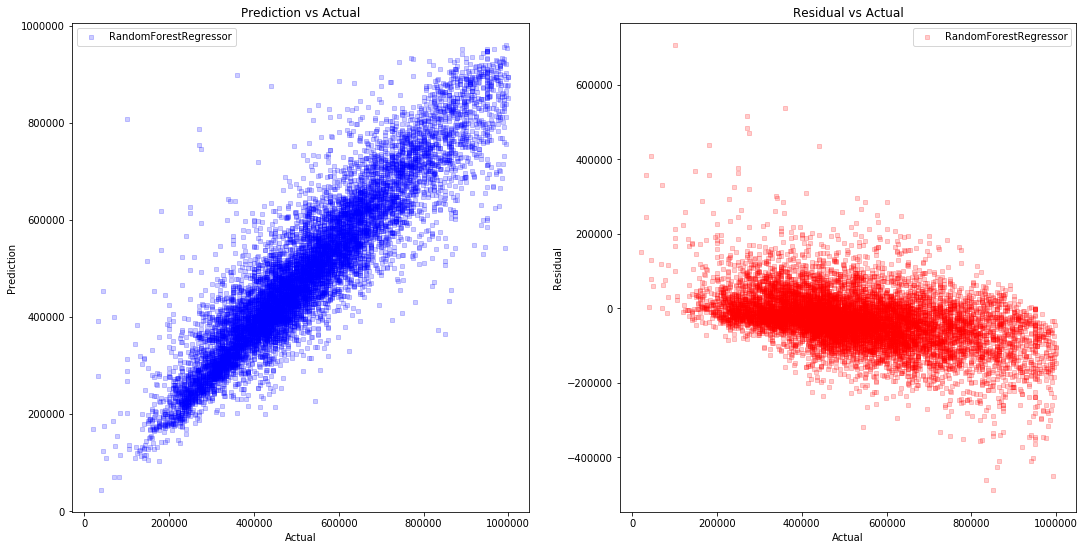

In [17]:
mm1.plot_residual()

In [19]:
# >= 1M
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
df_track_filter = df_track[df_track['sold_price']>=1000000]
print(df_track_filter.shape)
monthly_volume = int(df_track_filter.shape[0] / 24)
mm2 = ModelManager(df_track_filter, use_features, rf, time_series=True)
mm2.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 5062, 3036, 1012
[dp] train/valid/test size: 4049, 1013, 1012
[dp] validation step is skipped


(6074, 14)


279454.3714886828

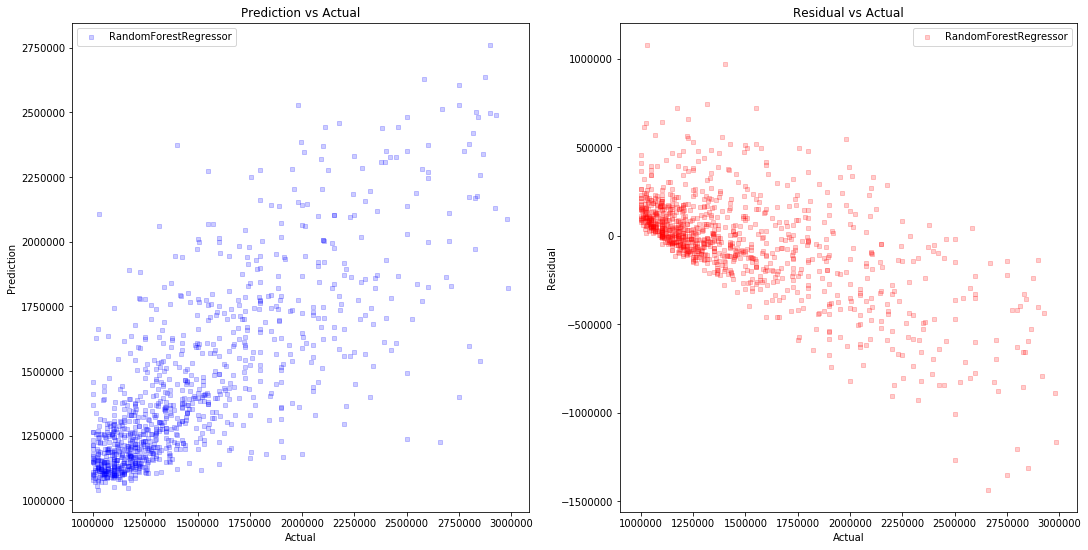

In [15]:
mm2.plot_residual()

In [24]:
def remeasure(df_checks):
    df_merged = pd.concat(df_checks)
    print(df_merged.shape)
    return sqrt(mean_squared_error(df_merged['predict'], df_merged['sold_price']))

df_check1 = mm1.get_result_df()
df_check2 = mm2.get_result_df()
remeasure([df_check1, df_check2])

(11484, 16)


112381.2247622272